# V.1 Exploring the green reds

### a) Write a function that will plot a scatterplot matrix of your red wine data.

In [32]:
import random
import math

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
try:
    wine_data = pd.read_csv('resources/winequality-red.csv', sep=';')
except FileNotFoundError:
    print('Set correct path')

In [3]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):

    num_examples, num_fitures = wine_data.shape
    fiture_names = wine_data.columns

    fig, axes = plt.subplots(num_fitures, num_fitures, figsize=(25, 25))
    fig.subplots_adjust(wspace=0, hspace=0)

    good_wines = wine_data[wine_data['quality'] > good_threshold]
    bad_wines = wine_data[wine_data['quality'] < bad_threshold]
    
    for x in axes.flat:
        x.xaxis.set_visible(False)
        x.yaxis.set_visible(False)

    for i, label in enumerate(fiture_names):
        axes[i, i].annotate(label.replace(' ', '\n'), (0.5, 0.5), va='center', ha='center', size=20, xycoords='axes fraction')
    
    for i in range(num_fitures):
        for j in range(i + 1, num_fitures):
            axes[i, j].scatter(good_wines[str(fiture_names[j])], good_wines[str(fiture_names[i])], marker='.', c='g', s=7)
            axes[i, j].scatter(bad_wines[str(fiture_names[j])], bad_wines[str(fiture_names[i])], marker='.', c='r', s=7)
            axes[j, i].scatter(good_wines[str(fiture_names[i])], good_wines[str(fiture_names[j])], marker='.', c='g', s=7)
            axes[j, i].scatter(bad_wines[str(fiture_names[i])], bad_wines[str(fiture_names[j])], marker='.', c='r', s=7)

    if save_plot == True:
        fig.savefig('wine_data.png')
    
    return fig

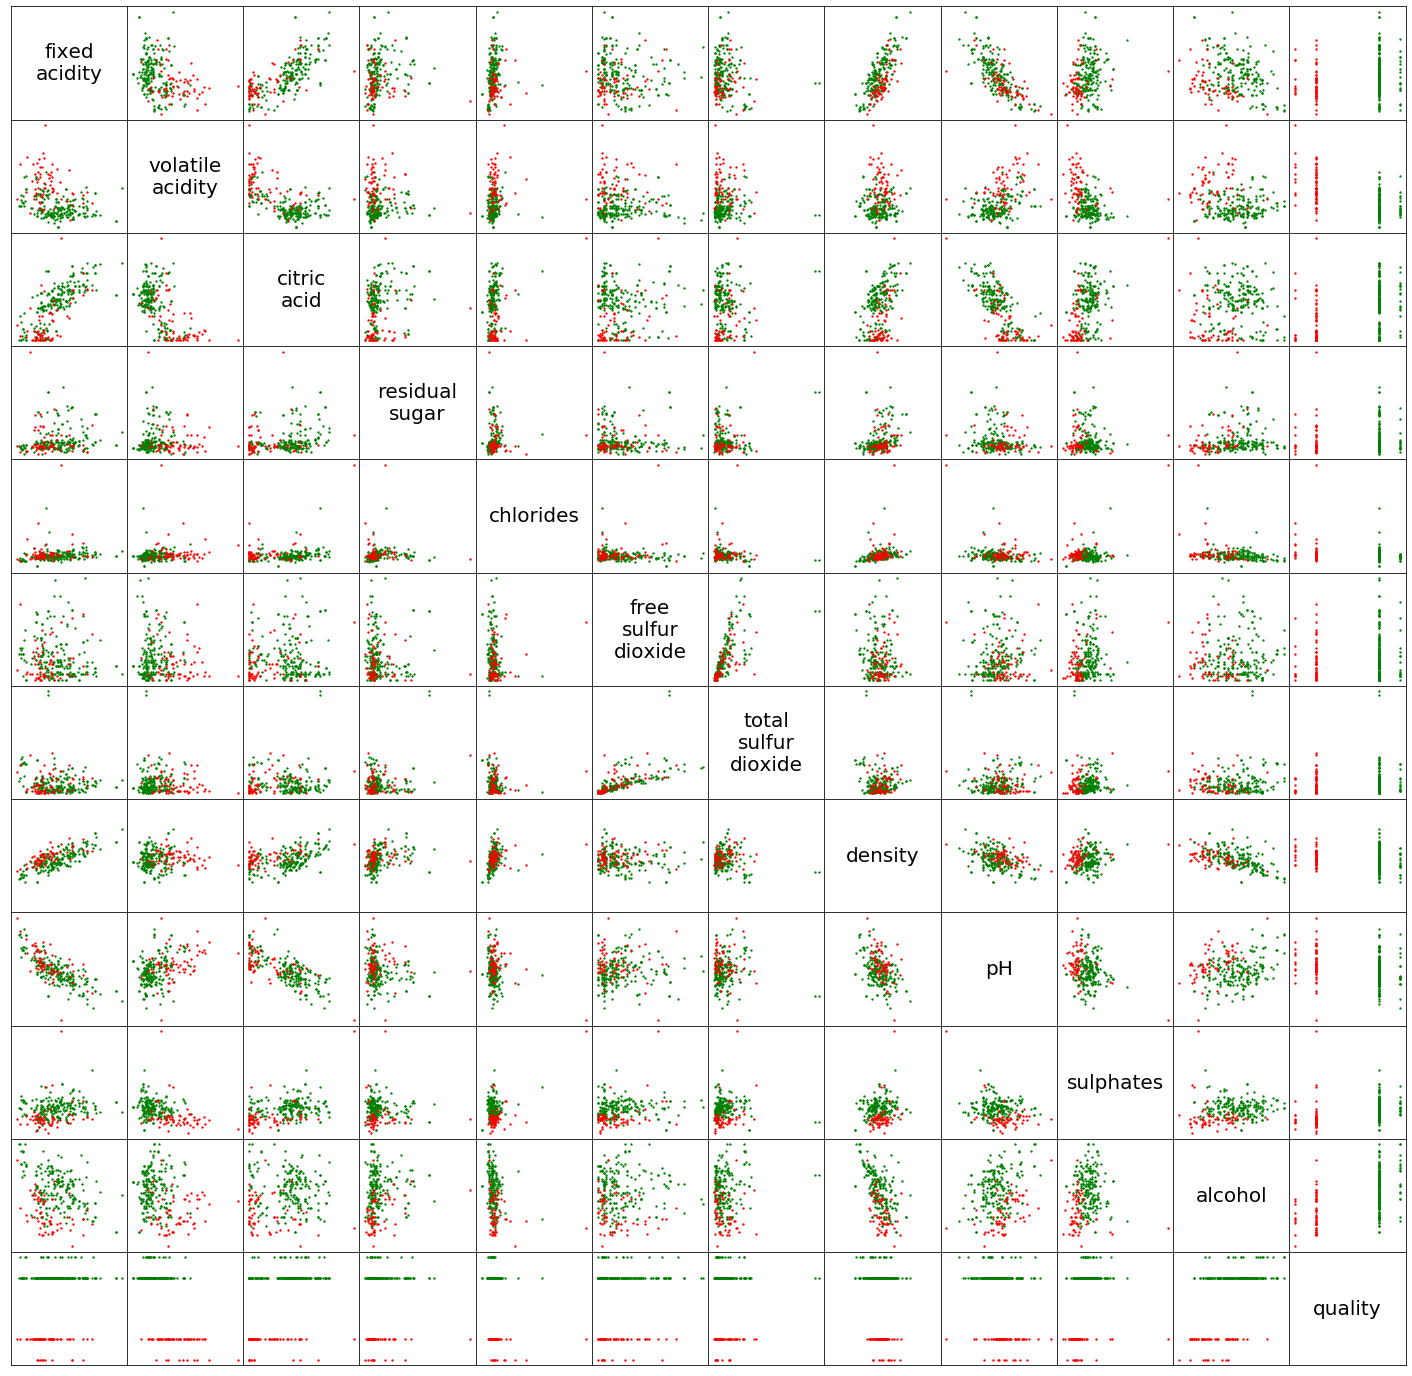

In [4]:
fig = plot_scatter_matrix(wine_data, 6, 5, True)
plt.show(fig)

### b) Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

Нам подходят все сочетания этих хим. элементов:
- Sulphates
- Alcohol
- Volatile acidity

Поскольку отобразив зависимость качества вина от различных сочетаний описанных химических элементов, можно сделать
вывод, что сочетания с вышеперечисленными химическими элементами наиболее визуально разделимые.

# V.2 Learning to perceptron

### a) Implement a perceptron that:

- Has randomly initialized weights and bias
- Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
- Utilizes the heaviside step activation function (discrete version)

### b) Implement a function for training the perseptron. Training function should take in the red wine data as a parameter and should:

- Have a way to specify number of training epochs
- Train your perceptron until it makes no errors, if training epochs is set to 0
- Have a way to specify learning rate
- Return a list of python tuples containing (performance): [(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]

### Implementing of MVC architecture
#### Main entity list:
- Analytic object (implemented analysis model)
- View object (plotting)
- Data handling object (service)

In [149]:
class DataService:
    
    def _feature_scaling(self, np_data):
        for i in range(0, np_data.shape[1] - 1):
            np_data[:,i] = (np_data[:,i] - np_data[:,i].min()) / (np_data[:,i].max() - np_data[:,i].min())
        return np_data
    
    def prepare_data(self, data, good_tresh, bad_tresh, feature_scaling=False):
        columns = data.columns
        criteria1 = data['quality'] <= bad_tresh
        criteria2 = data['quality'] >= good_tresh
        data_set = data[criteria1 | criteria2].to_numpy()
        data_set[data_set[:,-1] <= bad_tresh, -1] = 0
        data_set[data_set[:,-1] >= good_tresh, -1] = 1
        if not feature_scaling:
            return pd.DataFrame(data_set, columns=columns)
        return pd.DataFrame(self._feature_scaling(data_set), columns=columns)

    
    def get_Xy(self, df, f_columns):
        y = df['quality'].to_numpy()
        X = df[f_columns].to_numpy()
        return X, y

    

In [150]:
class BaseModel:
    
    def activation_func(self, h):
        return self.heaviside_func(h)
    
#     def calc_error_f1_score(self, output_y):
#         c_dict = {
#             'tp': 0,
#             'fp': 0,
#             'fn': 0,
#         }

#         for i, val in enumerate(self.y):
#             if val[0] and output_y[i][0]:
#                 c_dict['tp'] += 1
#             elif not val[0] and output_y[i][0]:
#                 c_dict['fp'] += 1
#             elif val[0] and not output_y[i][0]:
#                 c_dict['fn'] += 1
#         try:
#             precision = c_dict['tp'] / (c_dict['tp'] + c_dict['fp'])
#         except ZeroDivisionError:
#             return 0
#         try:
#             recall = c_dict['tp'] / (c_dict['tp'] + c_dict['fn'])
#         except ZeroDivisionError:
#             return 0
#         f1_score = 2 * ((precision*recall) / (precision+recall))
#         return int(f1_score)
    

    def hypothesis(self, feature_set, weights):
        return self.activation_func(np.array([sum(obj) for obj in feature_set * weights[1:]]) + weights[0])

    
    def heaviside_func(self, h):
        return np.where(h < 0, 0, 1)
    

In [152]:
class Perseptron(BaseModel):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def train(self, l_rate=0.001, epochs=0):
        epoch = 0
        result = list()
        weights = [random.choice([x/1000 for x in range(-1000, 1000)]) for _ in range(X.shape[1] + 1)]
        while True:
            errors = 0
            epoch += 1
            if epochs == epoch:
                return result
            for xi, yi in zip(self.X, self.y):
                update = (yi - self.hypothesis(np.array([xi]), weights)) * l_rate
                weights[1:] += update * xi
                weights[0] += update
                errors += int(update != 0.0)
            if epochs == 0:
                if errors == 0:
                    return result
            result.append((epoch, errors, weights[1:], weights[0]))
            


### c) Write a function that will take the output of the perceptron training function and the red wine data and generate two plots in one figure:

- The first plot should plot the number of errors the perceptron made as a function of epoch. Be careful with how you calculate errors
- The second plot should plot the decision boundary of your perceptron and also show 'good' and 'bad' wine data points on the final training epoch. This second plot should also shade 'good' and 'bad' areas
- The function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch

In [185]:
def decision_boundary(weights, range_):
    slope = list((-weights[0]/weights[2]) / (weights[0]/weights[1]))[0]
    b = list((-weights[0]/weights[2]))[0]
    return [x * slope + b for x in range_]

def plot_performance(performance, wine_data, good_tresh, bad_tresh, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundery for two factors
    """
    wine_data, quality = wine_data[0], wine_data[1]
    wine_data['quality'] = quality
    
    
    good_wines = wine_data[wine_data['quality'] == 1]
    bad_wines = wine_data[wine_data['quality'] == 0]
        
    
#     Data for first plot
    epochs = [curr_epoch[0] for curr_epoch in performance]
    errors = [err[1] for err in performance]
    weights = []
    
#     Determine an epoch for second plot
    if epoch == -1 or epoch > performance[-1][0]:
        weights = [performance[-1][-1]] + performance[-1][-2]
        epoch = performance[-1][0]
    elif epoch >= 0:
        weights = [performance[epoch-1][-1]] + performance[epoch-1][-2]
        epoch = performance[epoch-1][0]
    
    
#     Plotting
    fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plt1.set_title('Errors as a function of epoch')
    plt1.set_xlabel('epoch')
    plt1.set_ylabel('classification errors')
    
    plt2.set_title(f'Decision boundary on epoch: {epoch}')
    plt2.set_xlabel('alcohol')
    plt2.set_ylabel('pH')
    
    xoffset = (wine_data['alcohol'].max() - wine_data['alcohol'].min()) / len(wine_data)
    yoffset = (wine_data['pH'].max() - wine_data['pH'].min()) / len(wine_data)
    plt2.set_xlim(wine_data['alcohol'].min() - xoffset, wine_data['alcohol'].max() + xoffset)
    plt2.set_ylim(wine_data['pH'].min() - yoffset, wine_data['pH'].max() + yoffset)

    plt1.plot(epochs, errors)
    
    plt2.fill_between(decision_boundary(weights, range(-15, 15)),
                      range(-15, 15), -1, facecolor='#6EDD5E', alpha=0.3)
    plt2.fill_between(decision_boundary(weights, range(-15, 15)), range(-15, 15),
                     wine_data['pH'].max()+1, facecolor='#FFB4FA', alpha=0.3)
    
    plt2.scatter(bad_wines['alcohol'], bad_wines['pH'], s=13, color='#FF00F0', label=f'bad wines (>{good_tresh-1} score)')
    plt2.scatter(good_wines['alcohol'], good_wines['pH'], s=13, color='g', label=f'good wines (<{bad_tresh+1} score)')
    
    plt2.plot(decision_boundary(weights, range(-15, 15)), range(-15, 15), '--', label='Decision Boundary')
    plt2.legend(loc=1, bbox_to_anchor=(1.52, 1))


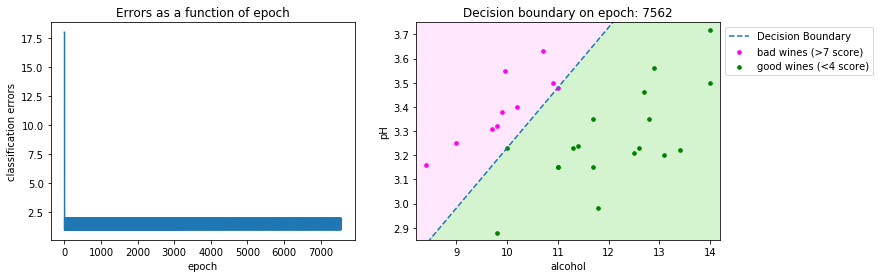

In [189]:
data_service = DataService()

df = data_service.prepare_data(wine_data, good_tresh=8, bad_tresh=3, feature_scaling=False)
X, y = data_service.get_Xy(df, ['pH', 'alcohol'])

perseptron = Perseptron(X, y)

plot_performance(perseptron.train(), [pd.DataFrame(X, columns=['pH', 'alcohol']), y], good_tresh=8, bad_tresh=3)

### d) Adding the feature scaling and using the function that was created in part "c)" to plot and verify that the perceptron is learning more efficiently.

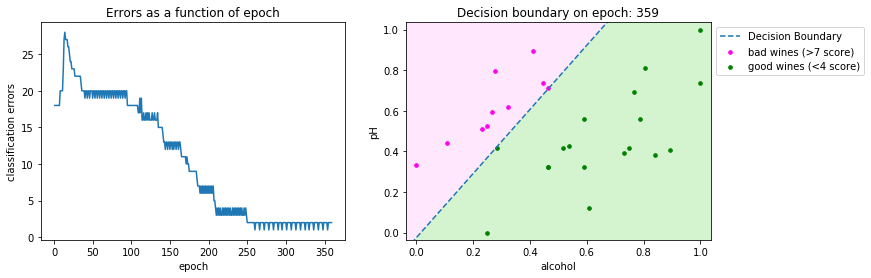

In [194]:
df = data_service.prepare_data(wine_data, good_tresh=8, bad_tresh=3, feature_scaling=True)
X, y = data_service.get_Xy(df, ['pH', 'alcohol'])

perseptron = Perseptron(X, y)

plot_performance(perseptron.train(), [pd.DataFrame(X, columns=['pH', 'alcohol']), y], good_tresh=8, bad_tresh=3)